This notebook was created in the context of 'Chapter 19 - Cascading Behaviour In Networks'.

The main goal is to create weekly CSV's so that we can observe the cascading behaviour in the network with a twist: this cascading behaviour is seen as the effect of node conversation (from one property to another) iteratively through the neighborhood.

### First Step : the nodes

Import dataset (start only with GB) and correct the dates

In [1]:
#Import GB videos
import pandas as pd
videosGB = pd.read_csv('../OriginalCSVs/GBvideos.csv', sep=',')

#process the dates
videosGB['trending_date'] = pd.to_datetime(videosGB['trending_date'], format='%y.%d.%m')
videosGB['publish_time'] = pd.to_datetime(videosGB['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')

#delete nodes without tags
videosGB = videosGB[videosGB.tags != '[none]']

#remove unnecessary statistics
nodesGB = videosGB.loc[:, ['video_id','title','channel_title','category_id','trending_date','publish_time','views','likes','dislikes','comment_count',]]

nodesGB.head()

,video_id,title,channel_title,category_id,trending_date,publish_time,views,likes,dislikes,comment_count
0,Jw1Y-zhQURU,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,26,2017-11-14,2017-11-10 07:38:29,7224515,55681,10247,9479
1,3s1rvMFUweQ,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,24,2017-11-14,2017-11-12 06:24:44,1053632,25561,2294,2757
2,n1WpP7iowLc,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-14,2017-11-10 17:00:03,17158579,787420,43420,125882
3,PUTEiSjKwJU,Goals from Salford City vs Class of 92 and Fri...,Salford City Football Club,17,2017-11-14,2017-11-13 02:30:38,27833,193,12,37
5,AumaWl0TNBo,How My Relationship Started!,PointlessBlogVlogs,24,2017-11-14,2017-11-11 17:00:00,1182775,52708,1431,2333


Now we'll create a function useful to group by dataframes weekly.

In [2]:
import datetime

def weekly_dataframe(df):
    #create DF array
    df_week = []
    temp_days = []
    start_day = df['trending_date'][0]

    #group by trending date
    group = df.groupby(['trending_date'])
    length = len(group)

    #group by week (adicionar os dias que faltam)
    for i in range(0,length+8):
        if i % 7 == 0 or i == length-1:
            if temp_days:
                temp_week = pd.concat(temp_days)
                temp_week = temp_week.drop_duplicates('video_id','last',False)
                df_week.append(temp_week)
            temp_days = []
        #por alguma razao nao existem registo para os dias 10 e 11 de janeiro e entre 8-14 abril
        if i != 57 and i != 58 and (i < 145 or i > 151):
            my_group = group.get_group(start_day + datetime.timedelta(days=i))
            temp_days.append(my_group)        
    return df_week

Create weekly datasate od nodes.

Week one example.

In [3]:
#generate nodes weekly dataframe
weekly_videosGB = weekly_dataframe(nodesGB)
weekly_videosGB[0].head()

,video_id,title,channel_title,category_id,trending_date,publish_time,views,likes,dislikes,comment_count
5,AumaWl0TNBo,How My Relationship Started!,PointlessBlogVlogs,24,2017-11-14,2017-11-11 17:00:00,1182775,52708,1431,2333
7,-N5eucPMTTc,CHRISTMAS HAS GONE TO MY HEAD,MoreZoella,22,2017-11-14,2017-11-10 19:19:43,1164201,57309,749,624
22,fiusxyygqGk,Marshmello - You & Me (Official Music Video),marshmello,10,2017-11-14,2017-11-10 15:00:03,3407008,207262,3167,13279
90,sLJdBmAeB_U,COME SHOPPING WITH ME AND TRY ON NEW CLOTHING ...,Inthefrow,26,2017-11-14,2017-11-07 19:00:50,87772,2617,86,192
92,mCx26FLXWuI,Seth Rollins & Dean Ambrose vs. Cesaro & Sheam...,WWE,17,2017-11-14,2017-11-07 04:52:25,1689382,24186,3330,3414


### Second Step : the edges

Create a new Sub Dataframe only with tags, trending date and ID

In [4]:
#sub dataframe
TagsVideosGB = videosGB.loc[:, ['video_id','tags']]

for index, tags in TagsVideosGB.iterrows():
    #tudo minuscula
    tags['tags'] = tags['tags'].lower()
    #remover pipes
    tags['tags'] = tags['tags'].split('"|"') 
    #compor a ultima tag
    size = len(tags['tags'])
    last = tags['tags'][size-1]
    tags['tags'][size-1] = last.split('"')[0]
    #compor a primeira tag
    tag1 = tags['tags'][0].split('|"')
    tags['tags'][0] = tag1[0]
    if len(tag1) == 2:
        tags['tags'].append(tag1[1])
        
#TODO retirar stop words e palavras com tamanho 1?

#adding trending date and num of viz
TagsVideosGB['trending_date'] = videosGB['trending_date']
TagsVideosGB['views'] = videosGB['views']

TagsVideosGB.head()

,video_id,tags,trending_date,views
0,Jw1Y-zhQURU,"[christmas, john lewis, christmas ad, mozthemo...",2017-11-14,7224515
1,3s1rvMFUweQ,"[snl, snl season 43, episode 1730, tiffany had...",2017-11-14,1053632
2,n1WpP7iowLc,"[eminem, on, water, aftermath/shady/interscope...",2017-11-14,17158579
3,PUTEiSjKwJU,"[salford city fc, salford, class of 92, univer...",2017-11-14,27833
5,AumaWl0TNBo,"[pointlessblog, pointlessblogvlogs, games, gam...",2017-11-14,1182775


Then we need to separate the edges weekly.

We'll create an hashmap <trending_week, edges>.

Week 1 example.

In [5]:
#array with 23 dataframes (one for each week) with the videos, tags and other information
weekly_tagsVideosGB = weekly_dataframe(TagsVideosGB)
weekly_tagsVideosGB[0].head()

,video_id,tags,trending_date,views
5,AumaWl0TNBo,"[pointlessblog, pointlessblogvlogs, games, gam...",2017-11-14,1182775
7,-N5eucPMTTc,"[zoe sugg, zoe, vlog, vlogging, vlogs, daily, ...",2017-11-14,1164201
22,fiusxyygqGk,"[selena gomez wolves, marshmello - alone, mars...",2017-11-14,3407008
90,sLJdBmAeB_U,"[inthefrow, come shopping with me, luxury beau...",2017-11-14,87772
92,mCx26FLXWuI,"[wwe, wrestling, wrestler, wrestle, superstars...",2017-11-14,1689382


### Third step : measuring popularity by tag

Now we need to define the most popular tags

Create an array of weeks, for each one create a dataframe with the list of tags and the popularity

*avgViews*: noViews / noVideos (with that tag)

In [6]:
#27 arrays (for each week) with all the tags and respective views
weekly_tagsPop = []

for week in weekly_tagsVideosGB:    
    #create a single list with all the lists of tags
    df_tags = pd.DataFrame({'tags':[], 'avgViews':[]})
    
    for index, video in week.iterrows():
        df_temp = pd.DataFrame({'tags': video['tags']})
        df_temp['avgViews'] = video['views']
        df_tags = pd.concat([df_tags,df_temp])
    
    #group by with the average of views
    g = df_tags.groupby(['tags'],as_index=False).mean()
    g = g.sort_values(by=['avgViews'], ascending=False)
    weekly_tagsPop.append(g)

Insert new column 'popularity' that verifies if that tag has more views than the average of total views (per week).
This step is optional and for statistics only.

Week 1 example.

In [7]:
popOrNot = lambda x, y: False if x < y else True 

for df in weekly_tagsPop:
    mean = df.avgViews.mean()
    df['popularity'] = df.apply(lambda x: popOrNot(x['avgViews'], mean), axis=1)

weekly_tagsPop[0].head()

,tags,avgViews,popularity
1154,ed sheeran,74009550.0,True
1160,edsheeran,74009550.0,True
3354,session,74009550.0,True
3179,remix,74009550.0,True
2372,lyrics,74009550.0,True


Verify the tags that are popular through the weeks.
Also for statistics only. Useful to choose the best tags.

In [8]:
df_base = pd.DataFrame({'tags':[]})

for df in weekly_tagsPop:
    #so tags populares dessa semana
    most_pop = df.loc[lambda df: df.popularity == True, ['tags']]
    if df_base.empty:
        df_base = most_pop 
    else:
        #df_base = pd.merge(df_base, most_pop, on='tags')
        #OU : merge com qualquer tag (pop ou nao)
        df_base = pd.merge(df_base, df.loc[:, ['tags']], on='tags')

#example with the first 15 tags
print(df_base[:15])

               tags
0        ed sheeran
1             remix
2    official video
3              live
4          official
5   late night show
6             jimmy
7           comedic
8               rap
9          comedian
10  stephen colbert
11             clip
12            celeb
13             joke
14           corden


### Forth Step: create weekly graphs

After chosing one tag, we should construct incremental weekly graphs with all videos with a certain tag.

Incremental graphs because we want to add to the original graph (week 1) the new videos that are coming up.

The videos will have a label (true or false) named 'popularity' indicating if the respective video belongs to the top 50% of views.

In [9]:
def filter_by_tag(tag):
    week_DFbytag = []
    i = 0
    #verify each week
    for week in weekly_tagsVideosGB:
        #extract the videos with the specified tag
        for index, video in week.iterrows():
            #add video to graph if the tag appears
            if tag not in video['tags']:
                week = week.drop(index)
        #add last week
        if i != 0:
            last_week = week_DFbytag[i-1]
            week = pd.concat([last_week,week])
        i = i+1
        #drop duplicates  
        week = week.drop_duplicates('video_id','last',False)
        #end of week
        week_DFbytag.append(week)
    return week_DFbytag

C:\Users\gomes\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


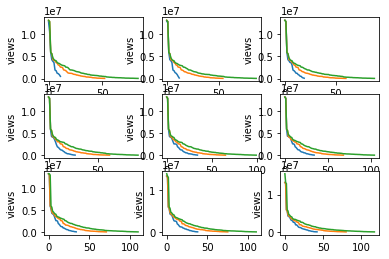

In [16]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

#hip, comedian
week_finalvideos = filter_by_tag('comedian')

subplots = [331,332,333,334,335,336,337,338,339]
i = 0

#make sure everything is alright
for week in week_finalvideos:
    week = week.sort_values(by=['views'], ascending=False)
    list_ = week['views'].tolist()
    #view tendencies for each week
    plt.subplot(subplots[i])
    plt.plot(list_)
    plt.ylabel('views')
    i = i+1
    if i%9 == 0:
        i = 0
plt.show()

After a quick look to the views graphs all over the weeks, we can conclud that there are 2 videos that have twice views than the average. So, I'll remove them so that the top 10% videos could be fairer.

C:\Users\gomes\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


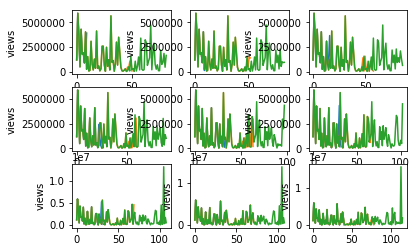

In [11]:
temp = []
subplots = [331,332,333,334,335,336,337,338,339]
i = 0

for week in week_finalvideos:
    for index, video in week.iterrows():
        if video['video_id'] == 'NWdc7PyZNLA' or video['video_id'] == 'p8XP7A7kvzM':
            week = week.drop(index)
    temp.append(week)
    
    #view tendencies for each week
    list_ = week['views'].tolist()
    plt.subplot(subplots[i])
    plt.plot(list_)
    plt.ylabel('views')
    i = i+1
    if i%9 == 0:
        i = 0
plt.show()

week_finalvideos = temp

Construct edges csv's

In [12]:
#edges: node1 id, node2 id, type (undirected)

def createWeeklyEdges(noWeek,weekly_video):
    df_week = pd.DataFrame({'Source':[], 'Target':[]})

    for index1, node1 in weekly_video.iterrows():
        for index2, node2 in weekly_video.iterrows():
            #no bidirectional connections
            if index2 > index1:
                #verify if the lists doesnt have tags in common, returns False if there is a connection
                res = set(node1['tags']).isdisjoint(set(node2['tags']))
                if res == False:
                    elem = pd.DataFrame({'Source':[node1['video_id']], 'Target':[node2['video_id']]})
                    if df_week.empty:
                        df_week = elem
                    else:
                        df_week = df_week.append(elem)
             
    df_week['Type'] = 'Undirected'
    #transform dataframe in csv
    df_week.to_csv('../CreatedCSVs/Cascading/edges_week'+str(noWeek)+'.csv',index=False)
    return

In [13]:
#create edges csv
count = 1
for weekly_videos in week_finalvideos:
    #for each week, compare every 2 nodes
    createWeeklyEdges(count, weekly_videos)
    print("created week edges "+str(count)+" ...")
    count = count + 1

created week edges 1 ...
created week edges 2 ...
created week edges 3 ...
created week edges 4 ...
created week edges 5 ...
created week edges 6 ...
created week edges 7 ...
created week edges 8 ...
created week edges 9 ...
created week edges 10 ...
created week edges 11 ...
created week edges 12 ...
created week edges 13 ...
created week edges 14 ...
created week edges 15 ...
created week edges 16 ...
created week edges 17 ...
created week edges 18 ...
created week edges 19 ...
created week edges 20 ...
created week edges 21 ...
created week edges 22 ...
created week edges 23 ...
created week edges 24 ...
created week edges 25 ...
created week edges 26 ...
created week edges 27 ...


Before exporting the nodes, we need to know which ones belongs to the top 50% of views.

In [14]:
#save the max views
def max_views(week):
    maxv = week.loc[week['views'].idxmax()]
    return maxv['views']

#calculate if it belongs to top 40% views
def topvideos(week,maxv):
    popOrNot = lambda x, y: False if x < y*0.6 else True 
    week['popularity'] = week.apply(lambda x: popOrNot(x['views'], maxv), axis=1)
    #add important info (title, channel and category)
    week['title'] = videosGB['title']
    week['channel_title'] = videosGB['channel_title']
    week['category_id'] = videosGB['category_id']
    return week

def export_nodes(week,count):
    newheader = ['id','tags','trending_date','views','popularity','Label','channel_title','category_id']
    week.to_csv('../CreatedCSVs/Cascading/nodes_week'+str(count)+'.csv',header=newheader,index=False)
    print("created week nodes "+str(count)+" ...")
    return

count = 1
#create csv for each week
for week in week_finalvideos:
    maxv = max_views(week)
    nodes_final = topvideos(week,maxv)
    export_nodes(nodes_final,count)
    count = count + 1

created week nodes 1 ...
created week nodes 2 ...
created week nodes 3 ...
created week nodes 4 ...
created week nodes 5 ...
created week nodes 6 ...
created week nodes 7 ...
created week nodes 8 ...
created week nodes 9 ...
created week nodes 10 ...
created week nodes 11 ...
created week nodes 12 ...
created week nodes 13 ...
created week nodes 14 ...
created week nodes 15 ...
created week nodes 16 ...
created week nodes 17 ...
created week nodes 18 ...
created week nodes 19 ...
created week nodes 20 ...
created week nodes 21 ...
created week nodes 22 ...
created week nodes 23 ...
created week nodes 24 ...
created week nodes 25 ...
created week nodes 26 ...
created week nodes 27 ...


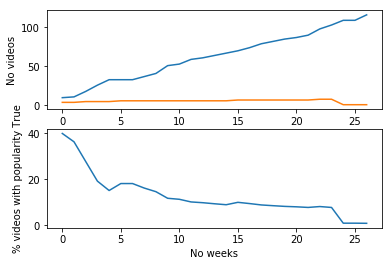

In [15]:
noPopular = []
noTotal = []
coef = []

for week in week_finalvideos:
    no = week['popularity'].value_counts()
    total = week.shape[0]
    d = no[True]/total
    noPopular.append(no[True])
    noTotal.append(total)
    coef.append(d*100)

plt.subplot(211)
plt.ylabel("No videos")
plt.xlabel("No weeks")
plt.plot(noTotal)
plt.plot(noPopular)

plt.subplot(212)
plt.ylabel("% videos with popularity True")
plt.xlabel("No weeks")
plt.plot(coef)

plt.show()